# Homework Set 5

In [1]:
%pylab inline
import pandas as pd

import sys
import fmt

Populating the interactive namespace from numpy and matplotlib


# Problem 1:

Use the following historical CMT data set for the this problem,

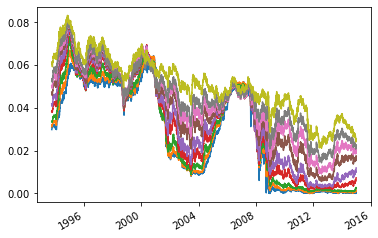

In [2]:
cmturl = "https://raw.githubusercontent.com/yadongli/nyumath2048/master/data/cmt.csv"
cmt_rates = pd.read_csv(cmturl, parse_dates=[0], index_col=[0])*.01

cmt_rates.plot(legend=False);
tenors = cmt_rates.columns.map(float)
tenorTags = ['T=%g' % m for m in tenors]

and suppose today's zero rate term structure is given below, and all rates are continously compounding:

In [3]:
t = map(float, cmt_rates.columns)
r = cmt_rates.iloc[-1, :].values

fmt.displayDF(pd.DataFrame(r, index=t, columns=['Zero Rate (%)']).T*100, fmt="4g")

,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0
Zero Rate (%),0.01,0.1,0.26,0.73,1.19,1.75,2.07,2.25,2.54


1. use the tension spline routine from previoius homework to build a tension spline of zero rate term structure $r(t)$ with $\lambda = 5$, you can assume $r(0) = 0$ if needed. Note that we are interpolating the zero rate instead of the cumulative yield here.
2. suppose the liquid market securities (the benchmarks) are 3M deposit (equivalent to zero coupon bond), and swaps paying semi-annual coupons with maturities matching the CMT quotes tenors;  use the curve you built to price these benchmark securities, assuming the deposits are quoted by the continous yield (zero rate) and swaps are quoted in break even spreads (par swap spreads).
3. use your bootstrap functions from the previous homework/lecture to bootstrap the zero rate curve from benchmark quotes from #2, show that the resulting curve is identical to the curve from #1. 
4. You have an aged receiver swap (receiving fixed) on the book with $100M notional, 6Y of remaining maturity and 5% semi-annual fixed coupon. Compute its deltas and hedge notionals to the benchmark instruments by bumping the market quotes of benchmark instruments (ie, deposit and swaps) and re-bootstrapping the IR curve, record the computation time for hedge notionals.
5. Suppose your system only computes the risks to the zero rates, compute the risk of the aged trade to zero rates, and the Jacobian matrix and use them to compute the hedge notionals, compare the results and computation time to the previous step. 

Hint:
* you can use the swap.py library from last homework to price swaps.
* please pay attention to the compounding, there are multiple compounding in this problem: all the zero rates are continuously compounded, the swaps pays coupon semi-annually, therefore the par swap quotes should be computed using the correct coupon frequency. The first deposit is quoted by yield (zero rate), which is countinuously compounded.
* The 3M deposit is equivalent to a 3M swap in risk profile, therefore, you may replace the 3M deposit by a quarterly par swap maturing at 3M as the first benchmark instruments during the bootstrap. It may ease the coding, as you can re-use the same swap pricer. But beware the par swap rate is different from continuous compounded zero rate, thus a proper conversion is required.

### Problem 1 Solution:

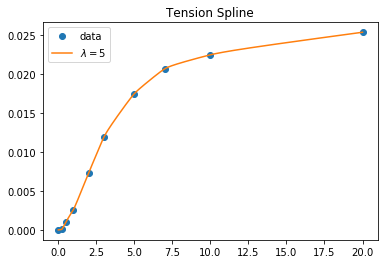

In [4]:
# Work for question 1

from swap import Swap, priceSwap, swapParSpread
import lin
import inst

# convert the map object of tenors to the array
tArray = np.array(list((map(float, list(cmt_rates.columns)))))

# this function is from lecture notebook
# a function that plot the tension spline
def plotTension(x, y, lbds, xd) :
    plot(x, y, 'o');
    title('Tension Spline');

    for lbd in lbds:
        ts = lin.RationalTension(lbd)
        ts.build(x, y)
        plot(xd, ts.value(xd))
    
    legend(['data'] + ['$\lambda = %.f$' % l for l in lbds], loc='best');

# define the time step for swaps maturities, time step should be between 0 and 20Y
xs_swaps = np.arange(0.01, tArray[-1] + 1e-6, 0.01)

# plot the result
plotTension(np.append(0., tArray), np.append(0, r), lbds = [5.], xd = xs_swaps)

1. <br>

The plot of the tension spline of zero rate term structure $r(t)$ with $\lambda = 5$, is showed above.

In [5]:
# Work for question 2

# build the zero rate curve given known zero rate, with r(0) = 0
zero = lin.RationalTension(lbd = 5.)
zero.build(np.append(0., tArray), np.append(0, r)) 

# define a function to compute par swap spreads given zero rate curve
# this function is modified by "y2pv" given in the lecture notebook
def z2parSpread(maturity, curve, freq):
    discf = lambda ts: np.exp(-curve(ts)*ts)
    return swapParSpread(maturity, discf, freq)

# define a function to compute pv of swaps given zero rate curve
# this function is modified by "y2pv" given in the lecture notebook
def z2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve(ts)*ts)
    return priceSwap(swap, discf)

# compute the break even spread for the swap with different maturies by the zero rate curve we built
parSpread_swaps = [z2parSpread(m, zero, freq = 2) if m > 0.25 else z2parSpread(m, zero, freq = 4) for m in tArray]

# create the benchmark instruments
bm_swaps = {}
for m, c in zip (tArray, parSpread_swaps):
    if (m > 0.25):
        bm_swaps[Swap(m, c, 2)] = 0
    else:
        bm_swaps[Swap(m, c, 4)] = 0

# display the result
fmt.displayDF(pd.DataFrame([parSpread_swaps], columns = tArray, index = ['Par swap spreads by maturity (%)'])*100, fmt="4g")

,0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0
Par swap spreads by maturity (%),0.01,0.1,0.2601,0.7292,1.186,1.735,2.044,2.22,2.488


2. <br>

The break even spread for the swap with different maturies, computed by zero rate term structure $r(t)$ with $\lambda = 5$, is showed above.

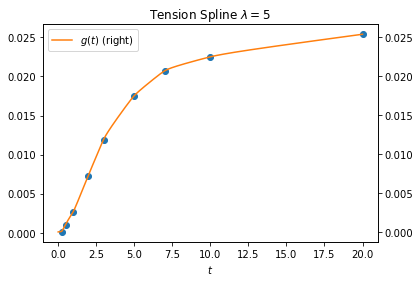

In [6]:
# Work for question 3

# this function is from lecture notebook
# plot the result of inst.iterboot
def plotboot(tsit, lbd, ax, tagsf) :
    xlabel('Time')    
    
    lbd_tag = '$\\lambda=%.f$' % lbd
    df = pd.DataFrame({'$t$':xs_swaps}).set_index(['$t$'])
    
    for tag, f in tagsf :
        df[tag] = f(tsit, xs_swaps) 
    
    plot(tArray, tsit(tArray), 'o')
    df.plot(ax = ax, secondary_y = [tagsf[0][0]], title = 'Tension Spline ' + lbd_tag)

# this part is mainly from lecture notebook and homework 4, with a little changes
tagsf = [("$g(t)$", lambda cv, xs_swaps : cv(xs_swaps))]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6, 4])

# compute the curve obtain by bootrstrap algorithm
tsit, e = inst.iterboot(bm_swaps, z2pv, lbd = 5., bds = [-5, 5], x0=0, its=1)

# plot the curve
plotboot(tsit = tsit, lbd = 5., ax = ax, tagsf = tagsf)

3. <br>

The plot of the zero rate curve, computed by benchmark quotes from question 2, is showed above. <br>

We find that this plot is identical to the plot in question 1.

In [7]:
# Work for question 4

import time

# compute the initial PV for benchmark instruments
pvs_swaps = {swap.maturity : z2pv(swap, zero) for swap in bm_swaps.keys()}

# define and compute the PV for aged receiver swap
agedSwap = Swap(6., .05, 2)
agedNotion = 100e6
agedPV = z2pv(agedSwap, zero)

# define the magnitude of pertubation as 1bps
pertubation = 1e-4

# record the start time for hedge notionals
q4Start = time.clock()

# consider the risks to the market quotes of benchmark instruments
# initialize arrays to record different results
jacob = np.zeros((len(tArray), len(tArray))) # Jacobian matrix
pv01_swaps = np.zeros(len(tArray)) # diagonal elements of Jacobian
db_swaps = np.zeros(len(tArray)) # delta
delta_swaps = np.zeros(len(tArray)) # normalized delta
hedgeNot_swaps = np.zeros(len(tArray)) # hedging notionals

# apply pertubation to the market quotes of each benchmark instruments
for i in range(len(parSpread_swaps)):
    parSpread_swaps_pert = parSpread_swaps.copy()
    parSpread_swaps_pert[i] += pertubation
    
    # create the benchmark instruments after pertubation
    bm_swaps_pert = {}
    for m, c in zip (tArray, parSpread_swaps_pert):
        if (m > 0.25):
            bm_swaps_pert[Swap(m, c, 2)] = 0
        else:
            bm_swaps_pert[Swap(m, c, 4)] = 0
    
    # bootstrap the new curve
    tsit_pert, e_pert = inst.iterboot(bm_swaps_pert, z2pv, lbd = 5., bds = [-5, 5], x0=0, its=3)
    
    # compute and record PV difference
    for j in range(len(tArray)):
        if (tArray[j] > 0.25):
            pert_swap = Swap(tArray[j], parSpread_swaps[j], 2)
            jacob[i][j] = (z2pv(pert_swap, tsit_pert) - z2pv(pert_swap, zero)) / pertubation
        else:
            pert_swap = Swap(tArray[j], parSpread_swaps[j], 4)
            jacob[i][j] = (z2pv(pert_swap, tsit_pert) - z2pv(pert_swap, zero)) / pertubation
    
    # compute and record delta and hedging notionals
    pv01_swaps[i] = jacob[i][i]
    db_swaps[i] = (z2pv(agedSwap, tsit_pert) - agedPV) / pertubation
    delta_swaps[i] = db_swaps[i]*agedNotion*pertubation
    hedgeNot_swaps[i] = -db_swaps[i]/pv01_swaps[i]*agedNotion*1e-6

# record the end time for hedge notionals and compute the time length
q4End = time.clock()
q4Time = q4End - q4Start

# display the result 
hi_names = ['%.2g Y' % t for t in tArray] # benchmark instruments
hedge_items = ['PV01 $= \\frac{\partial b}{\partial q}$', 
               '$\delta = 10^{-4} \\frac{\partial v}{\partial q}$', 'Hedge Not (\$MM)']
df_h_bmk = pd.DataFrame([pv01_swaps, delta_swaps, hedgeNot_swaps], 
                        columns = hi_names, index = hedge_items)
fmt.displayDF(df_h_bmk, "2f")

fmt.displayDF(pd.DataFrame([q4Time], index = ['Computation time for hedge notionals'], columns = ['time']), "4g")

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y
PV01 $= \frac{\partial b}{\partial q}$,-0.25,-0.50,-1.00,-1.99,-2.96,-4.83,-6.60,-9.07,-16.00
$\delta = 10^{-4} \frac{\partial v}{\partial q}$,-2.66,-56.18,-238.89,-835.66,690.99,"-33,465.85","-30,021.31",991.20,-10.05
Hedge Not (\$MM),-0.11,-1.12,-2.39,-4.20,2.34,-69.31,-45.51,1.09,-0.01


,time
Computation time for hedge notionals,3.872


4. <br>

After bumping the market quotes of benchmark instruments and re-bootstrapping the IR curve, the result of the aged receiver swap's deltas and hedge notionals to the benchmark instruments is showed above. <br>

The computational time for hedge notionals is also showed above, which is 3.872 second.

In [8]:
# Work for question 5

q5Start = time.clock()

# define the magnitude of pertubation as 1bps
pertubation = 1e-4

# consider the risks to the zero rates
# record the start time for hedge notionals
jacob_zero = np.zeros((len(tArray), len(tArray))) # Jacobian matrix 
pv01_swaps_zero = np.zeros(len(tArray)) # diagonal elements of Jacobian
db_swaps_zero = np.zeros(len(tArray)) # delta
delta_swaps_zero = np.zeros(len(tArray)) # normalized delta
hedgeNot_swaps_zero = np.zeros(len(tArray)) # hedging notionals

# apply pertubation to each zero rate
for i in range(len(r)):
    r_pert = r.copy()
    r_pert[i] += pertubation
    
    # create the new curve after pertubation
    zero_pert = lin.RationalTension(lbd = 5.)
    zero_pert.build(np.append(0., tArray), np.append(0, r_pert))
    
    # compute and record PV difference
    for j in range(len(tArray)):
        if (tArray[j] > 0.25):
            pert_swap = Swap(tArray[j], parSpread_swaps[j], 2)
            jacob_zero[i][j] = (z2pv(pert_swap, zero_pert) - pvs_swaps[pert_swap.maturity]) / pertubation
        else:
            pert_swap = Swap(tArray[j], parSpread_swaps[j], 4)
            jacob_zero[i][j] = (z2pv(pert_swap, zero_pert) - pvs_swaps[pert_swap.maturity]) / pertubation
    
    # compute and record delta and hedging notionals
    pv01_swaps_zero[i] = jacob_zero[i][i]
    db_swaps_zero[i] = (z2pv(agedSwap, zero_pert) - agedPV) / pertubation
    delta_swaps_zero[i] = db_swaps_zero[i]*agedNotion*pertubation
    hedgeNot_swaps_zero[i] = -db_swaps_zero[i]/pv01_swaps[i]*agedNotion*1e-6

# record the end time for hedge notionals and compute the time length
q5End = time.clock()
q5Time = q5End - q5Start

# display the result 
hedge_items_zero = ['PV01 $= \\frac{\partial b}{\partial g}$ for $g(t)$', 
                    '$\delta = 10^{-4} \\frac{\partial v}{\partial g}$ for $g(t)$', 'Hedge Not (\$MM)']
df_h_bmk_zero = pd.DataFrame([pv01_swaps_zero, delta_swaps_zero, hedgeNot_swaps_zero], 
                             columns = hi_names, index = hedge_items_zero)
fmt.displayDF(df_h_bmk_zero, "2f")

fmt.displayDF(pd.DataFrame([q5Time], index = ['Computation time for hedge notionals'], columns = ['time']), "4g")

,0.25 Y,0.5 Y,1 Y,2 Y,3 Y,5 Y,7 Y,10 Y,20 Y
PV01 $= \frac{\partial b}{\partial g}$ for $g(t)$,-0.25,-0.50,-1.00,-1.98,-2.92,-4.67,-6.20,-8.26,-13.37
$\delta = 10^{-4} \frac{\partial v}{\partial g}$ for $g(t)$,-5.30,-93.37,-435.60,"-1,164.63",-392.96,"-33,248.44","-28,140.93",911.43,-8.64
Hedge Not (\$MM),-0.21,-1.87,-4.36,-5.86,-1.33,-68.86,-42.66,1.00,-0.01


,time
Computation time for hedge notionals,0.02238


5. <br>

After computing the risk of the aged trade to zero rates, the result of the aged receiver swap's hedge notionals to the benchmark instruments and the diagonal elements of Jacobian matrix(PV01) is showed above. <br>

The computational time for hedge notionals is also showed above, which is 0.02238 second. <br>

When comparing the results of question 4 and question 5, we may conclude that both considering the risk of quotes and considering the risk of zero rates can produce similar hedging notionals. However, it is much more time-consuming when considering the risk of quotes and do the bootstrap.

## Problem 2

Following what you have done from the first problem, take the zero rates as fundamental risk factors in the market, and the aged bespoke swap:

1. suppose only 1Y, 5Y and 10Y IR swaps are liquid, devise the best hedging portfolio for the aged swap that minimizes the L-2 norm of the risks.
2. repeat step 1, but minimize the variance of the hedged portfolio instead, you can estimate the covariance matrix from the historical data.

Show the effectiveness of your hedging portfolio.

Hint: be careful on whether you should use the covariance of levels or changes of rates.

### Problem 2 Solution:

In [9]:
# Work for question 1

# compute best hedging portfolio that minimizes the L-2 norm
# imitate the code in lecture notebook
hi  = np.array([2,5,7])
hnm = [hi_names[i] for i in hi]

jac = np.array(jacob_zero)[hi, :].T
lsqm = np.linalg.inv(jac.T.dot(jac)).dot(jac.T)
opt_l2 = lsqm.dot(db_swaps_zero).T

# display the result
fmt.displayDF(pd.DataFrame([opt_l2], index = ['Best hedging portfolio that minimizes the L-2 norm'], columns = hnm), "4g")

,1 Y,5 Y,10 Y
Best hedging portfolio that minimizes the L-2 norm,0.09154,0.7338,-0.03184


1. <br>

The best hedging portfolio for the aged swap that minimizes the L-2 norm of the risks is showed above.

In [10]:
# Work for question2

# compute best hedging portfolio that minimizes the variance of hedged portfolio
# imitate the code in lecture notebook

# compute the historical covariance
histCov = cmt_rates.diff().cov()

varm = np.linalg.inv(jac.T.dot(histCov).dot(jac)).dot(jac.T).dot(histCov)
opt_var = varm.dot(db_swaps_zero)

# display the result
fmt.displayDF(pd.DataFrame([opt_var], index = ['Best hedging portfolio that minimizes the variance'], columns = hnm), "4g")

,1 Y,5 Y,10 Y
Best hedging portfolio that minimizes the variance,0.08424,1.027,0.08058


2. <br>

The best hedging portfolio for the aged swap that minimizes the variance of the hedged portfolio is showed above.

In [11]:
# compute the effectiveness of hedging portfolio

opt_ph = (db_swaps_zero / pv01_swaps_zero)[hi]

l2 = np.array([np.linalg.norm(jac.dot(np.array(p)) - db_swaps_zero, 2) 
               for p in [np.zeros(len(opt_l2)), opt_ph, opt_l2, opt_var]])*1e-4
vv = np.array([(jac.dot(np.array(p)) - db_swaps_zero).T.dot(histCov).dot((jac.dot(np.array(p)) - db_swaps_zero)) 
               for p in [np.zeros(len(opt_l2)), opt_ph, opt_l2, opt_var]])

# display the result
fmt.displayDF(pd.DataFrame([l2, np.sqrt(vv)], index = ['L2 norm of residual risk', 'Std dev of daily PnL'], 
                           columns = ['Unhedged', 'Partial hedged', 'Min residual risk', 'Min var'])*agedNotion, "5g")

,Unhedged,Partial hedged,Min residual risk,Min var
L2 norm of residual risk,"43,588","26,860","26,782","31,789"
Std dev of daily PnL,3.9531e+05,1.6349e+05,1.6661e+05,"28,966"


The effectiveness of both hedged portfolio, that minimizes L-2 norm and minimizes variance, are showed above.

Effectiveness can be obtained by comparing the results of hedged portfolio and unhedged portfolio.

## (Extra Credit) Problem 3
You now have four hedging portfolios from problem 1, a) a full hedging portfolio using all benchmark instruments b) a partial hedging portfolio that only use the 3 liquid swaps in the hedging portfolio of a, and keeping their notional the same as a, c) use only the three liquid instruments, and minimize the L-2 norm of the hedged risks d) same as c, but minimize the variance of daily PnL.

Now you want to compare the performance of these four hedging strategies, and make a recommendation to your head trader. What your head trader cares the most is to minimize the daily PnL of the hedged portfolios under the following common market scenarios:

1. rough parallel moves in quoted spread, which is the most common mode of movement in the market; the daily rates movements are typically only a few basis points, however, the daily rates movements can be as big as 20bps or more in turmoil market.
2. how the hedges performs if the curve become steeper of flatter.
3. In addition, your head trader wants to know the hedged risk profiles and the projected daily PnL volatiity (standard deviation) with the hedges,

You can use other metrics to help justify your recommendation of the best hedging strategy. You should include the unhedged trade as a reference in your analysis.

Hint: You certainly could directly perscribe the scenarios according to your head trader's description, but it is better to come up an objective and historical data driven way to define these common parallel moves and curve steepener/flatteners scenarios. 

## (Extra credit) Problem 4 
 
The Brownian bridge method can be easily extended to multi-dimensional correlated Brownian motions. Assuming we have two browniam motion $x(t), y(t)$ with a correlation of 50%,

1. write a program to construct correlated Brownian Bridge from the given terminal values, correlation matrix and time increments, note that here you need to draw correlated Gaussian random numbers to perserve the correlation of the Brownian Bridge increments.
2. draw multiple paths from different terminal values and verify that the correlation of the increments of your Brownian Bridge is indeed 50%. Note that the terminal values can be drawn directly using the covariance matrix, which is known. 
3. suppose that you forgot about the correlation and used independent Gaussian random numbers in step 1, and have drawn the Brownian Bridges using correlated terminal values, but independent increments; Plot the resulting terminal value correlation between $\rho\left(x(t), y(t)\right)$ of the resulting Brownian Bridge over time $t$, explain your observation.

### Problem 4 Solution:

In [12]:
# Work for question 1

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(11078211)

# The function that construct correlated Brownian Bridge 
#     from the given terminal values, correlation matrix and time increments
# Parameters:
#     ve: terminal values
#     cor: correlation matrix
#     t: time increments
# Return:
#     A correlated Brownian Bridge
def bwBridge(ve, cor, t):
    dt = arange(t) / t
    w_XY = np.cumsum(np.random.multivariate_normal(mean = np.zeros(2), cov = cor,size=[1, t]), 1)[0]
    w_X = w_XY[: , 0]
    w_Y = w_XY[: , 1]
    result = [w_X - (w_X[-1] - ve[0])*dt, w_Y - (w_Y[-1] - ve[1])*dt]
    return result

# define the correlation matrix
corr = [[1, 0.5], [0.5, 1]]
# define the parameter same as lecture notebook
nt = 100
dt = np.arange(nt)/nt

# define the terminal value and simulate the Brownian path
ve = np.zeros(2)
path_XY = bwBridge(ve = ve, cor = corr, t = nt)

1. <br>

The program that construct correlated Brownian Bridge is implemented above. 